In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
print('Finito!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
CLIENT_ID = 'AXDDEKH3ECP13GX1HOYTFLRUVHSBV1WMNCXN4CQKPEIXFZPP'
CLIENT_SECRET = 'L1ZRLH0QKAZAHDLMSWDOBXLTBC2DT5AFZP3DY3WVWVYLLME2'
VERSION = '20200410'
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude
def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [3]:
ny_data = get_new_york_data()

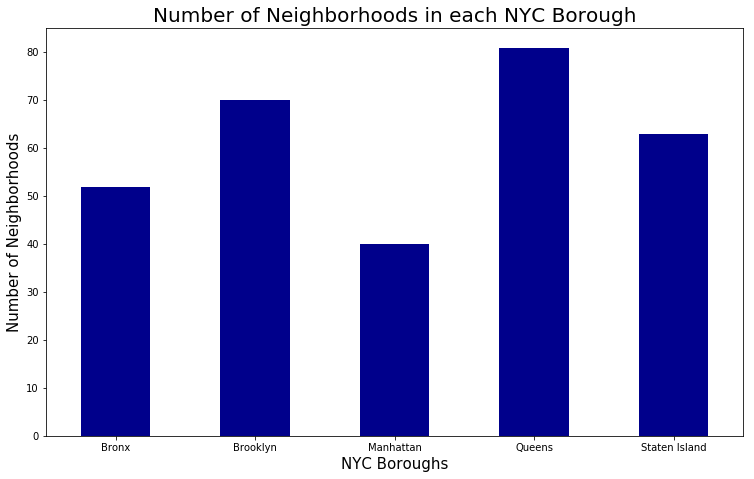

In [4]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(12.5,7.5), color="darkblue")
plt.title('Number of Neighborhoods in each NYC Borough', fontsize = 20)
plt.xlabel('NYC Boroughs', fontsize = 15)
plt.ylabel('Number of Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Manhattan historically is known to have many Italian Americans - it makes up almost a third of the Italian American population in New York City. Thus, for the least amount of neighborhoods, it is more densly populated with Italian Americans. This is a good indicator of where an Italian restaurant should open - there will be a lot of Italians wanting Italian food.

In [6]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

In [11]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv')

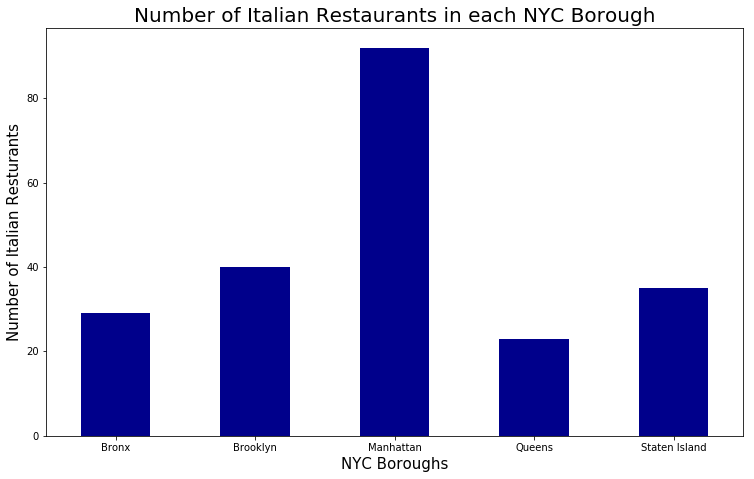

In [7]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(12.5,7.5), color = "darkblue")
plt.title('Number of Italian Restaurants in each NYC Borough', fontsize = 20)
plt.xlabel('NYC Boroughs', fontsize = 15)
plt.ylabel('Number of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

It would be ideal to have an Italian restaurant in a borough known to have Italian restaurants. This would help attract more potential customers. Manhattan seems like the best choice so far. Hopefully further research supports this choice.

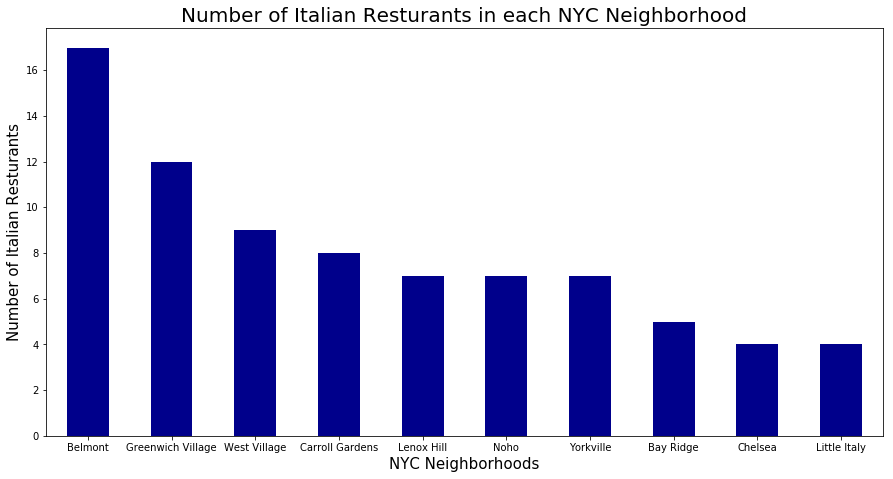

In [8]:
Number_Neighborhoods = 10
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(Number_Neighborhoods).plot.bar(figsize=(15,7.5), color="darkblue")
plt.title('Number of Italian Resturants in each NYC Neighborhood', fontsize = 20)
plt.xlabel('NYC Neighborhoods', fontsize = 15)
plt.ylabel('Number of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

7/10 of the NYC Neighborhoods above are located in Manhattan. This information further supports that Manhattan seems like the best choice. These Manhattan neighborhoods are Italian restaurant hot spots: Greenwich Village, West Village, Lenox Hill, Noho, Yorkvillille, Little Italy, Chelsea. It would be best to have an Italian restaurant in any of the 7/10 Manhattan neighborhoods, with the exception of Greenwich Village and West Village. This is because there is too much competition - it would be better to start an Italian restaurant in an area with less pre-existing Italian restaurants.

In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

If one is interested in opening up an Italian restaurant in an area that has good tips and/or 'likes' from customers, those could be used - that is why they are included in the code. But for right now, I am simply sticking to the ratings of the restaurants. Perhaps further down the road, if potential employees are wanting to find an Italian restaurant that provides good tips or a likeable atmosphere, I can include the tips and 'likes' portion.

In [90]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv')

In [ ]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

As shown above, Manhattan also as the highest average rating for Italian restaurants. Further confirming that Manhattan is the best borough to have an Italian restaurant.

In [ ]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

As shown above, 6 out of 10 of the neighborhoods that have the highest average rating for Italian restaurants are located in Manhattan. All but Noho and Greenwich Village have more than one or two restaurants, though. So starting an Italian restaurant in Noho or Greenwich Village would be more ideal, as there will be more potential customers nearby. However, Greeniwch Village has 12 Italian restaurants already, so there might be too much competition. Therefore, Noho would be the perfect location to set up shop. It has 6 Italian restaurants already, which will not be too much competition and it will allow for more potential customers. Noho also has a 8.76 rating out of 10, which is really good and the fourth best overall highest average rating.